In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm

# Capstone Project - Function 2

## Function 2 - Optimising Noisy Models

**Problem Description** This corresponds to trying to optimise an unknown machine learning model. However, the initialization of the model is very important, meaning your observations will be very noisy, and the problem might have a lot of local optima! You are trying to make the model’s log-likelihood as large as possible.

**Acquisition Function found to be the most efficient over time:** Expected Improvement with Knowledge Gradient

**Kernel Idea (evolved over time from simple default kernel usage to parametrized kernel based on inputs/outputs and function context):**

The Matérn kernel is a generalization of the RBF and the absolute exponential kernel, and it has an additional parameter that controls the smoothness of the resulting function. This can be particularly useful in our case, where the function may not be very smooth due to the presence of many local optima.
Gaussian Process Regression also assumes that your function observations are noisy, so we might want to include a White Noise kernel in our model to account for measurement noise. This is especially important if our model’s log-likelihood evaluations are noisy.

The Matern kernel is specified with a length_scale and nu (set to 1.5).
WhiteKernel is used to model the nose.
ConstantKernel is used as a scaling factor.

### 1.Loading the available data:
Here we first load the available datasets (1 and 2), then we add our weekly inputs/outputs to the dataset. 

In [4]:
X = np.load('initial_data/function_2/initial_inputs.npy')
Y = np.load('initial_data/function_2/initial_outputs.npy')
X2 = np.load('initial_data2/function_2/initial_inputs.npy')
Y2 = np.load('initial_data2/function_2/initial_outputs.npy')

X = np.concatenate((X,X2), dtype = float)
Y = np.concatenate((Y,Y2), dtype = float)

# Precision notation
np.set_printoptions(suppress=False)

# Adding knwon inputs/outputs from previous weeks
Xn = np.array(
[
    [0.111111, 0.111111],
    [0.751818, 0.268989],
    [0.835275, 0.701120],
    [0.73, 0.90054],
    [0.729933, 0.900501],
    [0.869851, 0.717543],
    [0.885227, 0.712664],
    [0.702608, 0.926588],
    [0.759334, 0.975316],
    [0.772608, 0.996588],
    [0.701524, 0.914337],
    [0.705764, 0.914692],
    [0.687786, 0.905392],
    [0.689017, 0.905793],
    [0.678296, 0.450519], 
    [0.652733, 0.486296],
    [0.747631, 0.428879],
    [0.772824, 0.435526],
    [0.682163, 0.386657],
    [0.689922, 0.395261],
    [0.667861, 0.368018],
    [0.66632,  0.368018]
])
X = np.concatenate((X,Xn), dtype = float)

Yn = np.array(
[
    -0.044763,
    0.3626224448,
    0.2312517935,
    0.6054864317,
    0.5260162569,
    0.535473333,
    0.3072606735408653,
    0.6153504789,
    0.2586156254,
    0.120894441,
    0.6028361926,
    0.6266229267,
    0.5565427993, 
    0.6042382161,
    0.4938959826,
    0.3467395036,
    0.4467626261,
    0.1954733073,
    0.6400282351,
    0.589727708,
    0.5151023817,
    0.357422389
])
Y = np.concatenate((Y,Yn), dtype = float)

In [5]:
print("X:\n")
print(X)
print("\n")
print("Y:\n")
print(Y)

X:

[[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]
 [0.33162594 0.08049911]
 [0.10053279 0.47759524]
 [0.67793216 0.87370355]
 [0.13495584 0.52115767]
 [0.53715567 0.24471459]
 [0.6591284  0.63064156]
 [0.47045207 0.53376825]
 [0.72120239 0.36450644]
 [0.7227338  0.43801822]
 [0.24066761 0.14122907]
 [0.111111   0.111111  ]
 [0.751818   0.268989  ]
 [0.835275   0.70112   ]
 [0.73       0.90054   ]
 [0.729933   0.900501  ]
 [0.869851   0.717543  ]
 [0.885227   0.712664  ]
 [0.702608   0.926588  ]
 [0.759334   0.975316  ]
 [0.772608   0.996588  ]
 [0.701524   0.914337  ]
 [0.705764   0.914692  ]
 [0.687786   0.905392  ]
 [0.689017   0.905793  ]
 [0.678296   0.450519  ]
 [0.652733   0.486296  ]
 [0.747631   0.428879  ]
 [0.772824   0.435526  ]
 [0.682163   0.386657  ]
 [0.689922   0.395261

In [6]:
# We look at and store the max output we obtained until now, and its related input values.
y_max = np.max(Y)
print("Max output until now: ", y_max, "which corresponds to input: ", X[np.where(Y == y_max)][0])

Max output until now:  0.6948320857901906 which corresponds to input:  [0.7227338  0.43801822]


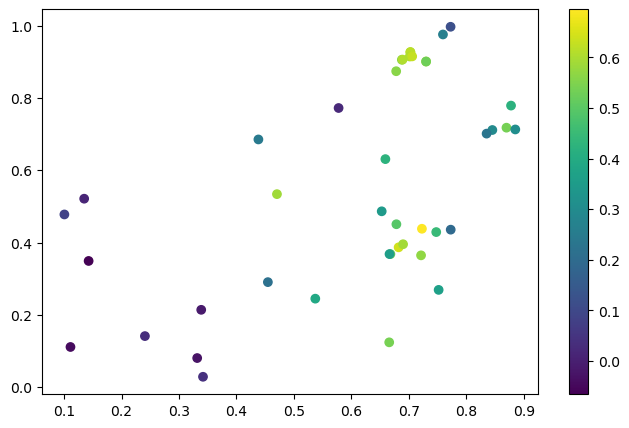

In [7]:
# Plot the two dimensions for visibility, as long as it's less than 4 dimensions, it can help.
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.scatter(X[:, 0], X[:, 1], c = Y)
plt.colorbar();

### 2. Build a Bayesian Model
Here we will build the bayesian model using Gaussian Process Regression (GPR). This method was explored in the course and is also the method recommended by the litterature.
GPR is widely used in blackbox machine learning models due to its representation flexibility and inherent capability to quantify uncertainty over predictions.

Advantages:
- Flexibility: GPR is a non-parametric method, meaning it makes fewer prior assumptions about the form of the function that maps inputs to outputs.
- Uncertainty Quantification: One of the key advantages of GPR is its ability to provide a measure of uncertainty along with predictions.
- Kernel Functions: GPR uses kernel functions to define the similarity between data points. This allows the model to capture complex patterns and structures in the data. We played with kernel functions during the full capstone project to find the best candidate.
- Prior Knowledge Incorporation: GPR allows for the incorporation of prior knowledge through the use of different kernel functions.
- Surrogate Modeling: GPR is often used as a surrogate model in optimization problems, where the goal is to find the best parameters of a blackbox function that is expensive to evaluate. 

Inconvenients:
- Computation resources: It can be computationally expensive for large datasets, and choosing the right kernel function can be challenging.

#### Approach for Kernel and parameters

The Matern kernel is specified with a length_scale and nu (set to 1.5).
WhiteKernel is used to model the nose.
ConstantKernel is used as a scaling factor.

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel as W

# Define the kernel function
kernel = C(1.0, (1e-3, 1e2)) * Matern(length_scale=0.5, length_scale_bounds=(1e-2, 1e1)) + W(noise_level=1, noise_level_bounds=(1e-5, 1e1))

# Gaussian Process Regression
gpr = GaussianProcessRegressor(kernel=kernel, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=11)
gpr.fit(X, Y)

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=11)

On top of our GPR model, we need to use an *acquisition function*, this was explained in Function 1 Notebook. 

**Which acquisition function to use?**

During our captstone weeks, we identified several acquisition functions (AF) from the literature as discussed previously (in Notebook of function 1). However, for function 2, we know this is a noisy function and we found an additional acquisition function in the literature: Expected Improvement with Knowledge Gradiant, which we will add to our arsenal for this specific function next to the already established acquisition functions.

### 3. Acquisition Function 1 - Upper Confidence Bound

Upper-Confidence Bound action selection uses uncertainty in the action-value estimates for balancing exploration and exploitation. Since there is inherent uncertainty in the accuracy of the action-value estimates when we use a sampled set of rewards thus UCB uses uncertainty in the estimates to drive exploration.
We started the captstone with high exploration (ucb = mean + 1.96 * standard_deviation) but ended up with more exploitation (1.96 -> 0.86) when inputs were converging. 

In [9]:
# To optimize the acquisition function, we will simply use gridsearch over a space of 250.000 gridpoints
# We want to stay close to the local maxima
x1 = np.linspace(X[np.where(Y == y_max)][0][0]-0.07, X[np.where(Y == y_max)][0][0]+0.07, 2000)
x2 = np.linspace(X[np.where(Y == y_max)][0][1]-0.07, X[np.where(Y == y_max)][0][1]+0.07, 2000)
X_grid = []
for i in range(len(x1)):
    for j in range(len(x2)):
        X_grid.append([x1[i], x2[j]])
X_grid = np.array(X_grid)

mean, std = gpr.predict(X_grid, return_std = True)

ucb1 = mean + 0.86 * std

idx_max = np.argmax(ucb1)
UB_NextQuery = X_grid[idx_max]

print("UCB - Next Query - Idea 1: ", UB_NextQuery)

UCB - Next Query - Idea 1:  [0.70469978 0.41263053]


### 4. Acquisition Function 2 - Probability of Improvement

The Probability of Improvement (PI) is an acquisition function which chooses the next query point as the one which has the highest probability of improvement over the current best observation. 
In other words, for each candidate point x, it assigns the probability of f(x) being larger than our current best f(x*). 
This helps balance the trade-off between exploration (probing areas of the search space where the outcome is uncertain) and exploitation (probing areas where the model predicts a good outcome).

In [10]:
# Compute PI values for candidate points
def compute_pi(x):
    mu, sigma = gpr.predict(X_grid, return_std = True)
    z = (mu - y_max) / sigma
    pi = norm.cdf(z)
    return pi

# Evaluate PI for a range of candidate points
pi_values = compute_pi(X_grid)

# Choose the next point with maximum PI value
next_idx = np.argmax(pi_values)
PI_NextQuery = X_grid[next_idx]

print("PI - Next Query: ", PI_NextQuery)

PI - Next Query:  [0.70476982 0.41270056]


### 5. Acquisition Function 3 - Thompson Sampling

Thompson Sampling is a heuristic for decision-making problems that balances exploration and exploitation. It works by sampling parameters from the posterior distribution, then choosing the action that maximizes the expected reward.

In [9]:
x1 = np.linspace(X[np.where(Y == y_max)][0][0]-0.07, X[np.where(Y == y_max)][0][0]+0.07, 1000)
x2 = np.linspace(X[np.where(Y == y_max)][0][1]-0.07, X[np.where(Y == y_max)][0][1]+0.07, 1000)
X_grid = []

for i in range(len(x1)):
    for j in range(len(x2)):
        X_grid.append([x1[i], x2[j]])
X_grid = np.array(X_grid)

# Compute Thompson Sampling values for candidate points
def compute_thompson(x):
    mu, sigma = gpr.predict([x], return_std=True)
    sample = np.random.normal(mu, sigma)
    return sample

# Evaluate Thompson Sampling for a range of candidate points
thompson_values = [compute_thompson(x) for x in X_grid]

# Choose the next point with maximum Thompson Sampling value
next_idx = np.argmax(thompson_values)
TS_NextQuery = X_grid[next_idx]

print("Thompson Sampling - Next Query: ", TS_NextQuery)

Thompson Sampling - Next Query:  [0.67095202 0.37530551]


### 6. Acquisition Function 4 - Bayesian Expected Losses

Bayesian Expected Loss is the expected value of a loss function with respect to the posterior distribution. It's used in decision-making to compare actions, where the preferred action is the one for which the posterior expected loss is smaller. This concept is central to Bayesian decision theory.

In [10]:
# Compute the expected loss for candidate points
def compute_expected_loss(x):
    mu, sigma = gpr.predict([x], return_std=True)
    z = (mu - y_max) / sigma
    expected_loss = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
    return expected_loss

expected_loss_values = [compute_expected_loss(x) for x in X_grid]

# Choose the next point with minimum expected loss
next_idx = np.argmin(expected_loss_values)
BL_NextQuery = X_grid[next_idx]

print("Bayesian Expected Loss - Next Query: ", BL_NextQuery)

Bayesian Expected Loss - Next Query:  [0.78152259 0.43626647]


### 7. Acquisition Function 5 - Expected Improvement

Expected Improvement (EI) is an acquisition function which selects the next point to sample by maximizing the expected improvement over the current best estimate. Unlike Probability of Improvement, EI considers not just the probability, but also the magnitude of the potential improvement.

In [11]:
# Compute Expected Improvement for candidate points
def compute_expected_improvement(x):
    mu, sigma = gpr.predict([x], return_std=True)
    f_best = np.max(Y)
    z = (mu - f_best) / sigma
    ei = (mu - f_best) * norm.cdf(z) + sigma * norm.pdf(z)
    return ei

# Evaluate expected improvement for a range of candidate points
x1 = np.linspace(X[np.where(Y == y_max)][0][0]-0.1, X[np.where(Y == y_max)][0][0]+0.07, 1000)
x2 = np.linspace(X[np.where(Y == y_max)][0][1]-0.1, X[np.where(Y == y_max)][0][1]+0.07, 1000)
X_grid = np.array([[a, b] for a in x1 for b in x2])

ei_values = [compute_expected_improvement(x) for x in X_grid]

# Choose the next point with maximum EI value
next_idx = np.argmax(ei_values)
EI_NextQuery = X_grid[next_idx]

print("Expected Improvement - Next Query: ", EI_NextQuery)

Expected Improvement - Next Query:  [0.6421332  0.33801822]


### 8. Acquisition Function 6 - Expected Improvement with Noise - Knowledge Gradient

Expected Improvement with Knowledge Gradient (EI-KG)  combines the benefits of Expected Improvement, which considers the magnitude of potential improvement, with the Knowledge Gradient, which quantifies the expected one-step improvement in the estimate of the best mean. This combination allows EI-KG to balance exploration and exploitation effectively. This AF is particularly suited for noisy functions due to its ability to handle uncertainty and variability in the data. It incorporates the covariance information provided by the Gaussian Process model, which allows it to account for noise in the observations.

In [8]:
# Compute Knowledge Gradient for candidate points
def compute_knowledge_gradient(x):
    mu, sigma = gpr.predict([x], return_std=True)
    f_best = np.max(Y)
    z = (mu - f_best) / sigma
    kg = sigma * norm.pdf(z)  # KG acquisition function
    return kg

expected_loss_values = [compute_knowledge_gradient(x) for x in X_grid]

# Choose the next point with maximum KG value
next_idx = np.argmax(expected_loss_values)
EIKG_NextQuery = X_grid[next_idx]

print("Knowledge Gradient - Next Query: ", EIKG_NextQuery)

Knowledge Gradient - Next Query:  [0.6527338  0.36801822]


## Predict Output for next query: select next inputs
Based on the next queries found using our set of acquisition functions, we use the prediction of the model to see which prediction would maximizse the output (potentially) and send the top 1 or 2 each week to the form. 

In [13]:
formatted_UCB = "{}{:.6f}-{:.6f} -> {}".format("UCB: ",UB_NextQuery[0],UB_NextQuery[1], gpr.predict([UB_NextQuery]))
formatted_PI = "{}{:.6f}-{:.6f} -> {}".format("PI: ",PI_NextQuery[0],PI_NextQuery[1], gpr.predict([PI_NextQuery]))
formatted_TS = "{}{:.6f}-{:.6f} -> {}".format("TS: ",TS_NextQuery[0],TS_NextQuery[1], gpr.predict([TS_NextQuery]))
formatted_BL = "{}{:.6f}-{:.6f} -> {}".format("BL: ",BL_NextQuery[0],BL_NextQuery[1], gpr.predict([BL_NextQuery]))
formatted_EI = "{}{:.6f}-{:.6f} -> {}".format("EI: ",EI_NextQuery[0],EI_NextQuery[1], gpr.predict([EI_NextQuery]))
formatted_EIKG = "{}{:.6f}-{:.6f} -> {}".format("EIKG: ",EIKG_NextQuery[0],EIKG_NextQuery[1], gpr.predict([EIKG_NextQuery]))

print(formatted_UCB)
print(formatted_PI)
print(formatted_TS)
print(formatted_BL)
print(formatted_EI)
print(formatted_EIKG)

UCB: 0.667861-0.368018 -> [0.6005256]
PI: 0.666321-0.368018 -> [0.599244]
TS: 0.670952-0.375306 -> [0.60543688]
BL: 0.781523-0.436266 -> [0.23328285]
EI: 0.642133-0.338018 -> [0.55995473]
